# Implementing a Stock-Flow Consistent macroeconomic model in Python

Over the last few years I've been developing, on and off, [FSIC](https://github.com/ChrisThoung/fsic), a Python package for macroeconomic modelling. It's a (perennial) work in progress. While I'm pretty happy with the user-facing elements, the implementation has always been a bit of a sandbox for me to learn Python. And it shows. It's been a learning process and there's a lot I'd do differently now.

This post documents a [streamlined/barebones re-implementation](https://github.com/ChrisThoung/website/tree/master/code/2018-07-08_fsic_pc) of the core of the package with an example.

## Godley and Lavoie's (2007) model of government money with portfolio choice

Chapter 4 of Godley and Lavoie (2007) sets out Model *PC*, an 11-equation [Stock-Flow Consistent (SFC) model](https://en.wikipedia.org/wiki/Stock-Flow_consistent_model) of government money with portfolio choice. The model extends [Model *SIM*](http://www.christhoung.com/2015/12/08/sim-graph/) from Chapter 3 of Godley and Lavoie (2007). Specifically, in addition to (high-powered) money, Model *PC* introduces short-term government securities (bills), which are an interest-paying financial asset. With two financial assets in the model, households must make a portfolio decision to allocate their wealth between money and bills, balancing the:

1. *transactions* motive for holding cash
2. *speculative* motive for investing in financial assets which yield a return

The national income identity is the same as in Model *SIM*, reflecting a closed, pure services economy. Production/income $\left( Y \right)$ equals the sum of consumption $\left( C \right)$ and government expenditure $\left( G \right)$. The equation numbers match those in Godley and Lavoie (2007):

$$\begin{equation} \tag{4.1} Y = C + G \end{equation}$$

Bills held by households $\left( B_h \right)$ pay interest at the prevailing rate $\left( r \right)$. Interest payments are an additional and taxable source of income for households and appear in the equations for both disposable income $\left( YD \right)$ and taxes $\left( T \right)$:

$$\begin{equation} \tag{4.2} YD = Y - T + r_{-1} \cdot B_{h-1} \end{equation}$$

$$\begin{equation} \tag{4.3} T = \theta \cdot \left( Y + r_{-1} \cdot B_{h-1} \right) \qquad \theta < 1 \end{equation}$$

Each period, households receive interest on their holdings of bills from the previous period and at the previous period's interest rate. Interest payments enter the above equations with a one-period lag.

To avoid complications to do with capital gains, the assumption is that bills have a fixed price of one unit.

### Portfolio allocation

In the model, households make a two-stage, hierarchical decision:

1. a *consumption* decision: how much to spend (and, conversely, how much to save)
2. a *portfolio* decision: how to allocate savings (wealth)

Consumption is a function of disposable income and accumulated wealth $\left( V \right)$. The $\alpha_1$ and $\alpha_2$ parameters are the propensities to consume out of each, respectively:

$$\begin{equation} \tag{4.5} C = \alpha_1 \cdot YD + \alpha_2 \cdot V_{-1} \qquad 0 < \alpha_2 < \alpha_1 < 1 \end{equation}$$

Wealth changes each period according to the difference between disposable income and consumption i.e. saving:

$$\begin{equation} \tag{4.4} V = V_{-1} + \left( YD - C \right) \end{equation}$$

The portfolio decision involves a choice to allocate wealth between money $\left( H \right)$ and bills.

Godley and Lavoie (2007) follow the Brainard-Tobin approach in which households wish to hold a certain proportion of their wealth in bills $\left( \lambda_0 \right)$ and the rest $\left( 1 - \lambda_0 \right)$ as money. The proportions adjust for:

1. the rate of return on bills: demand increases with the interest rate (the speculative motive)
2. the ratio of disposable income to wealth (the transactions motive)

Tobin's wealth/adding-up constraint holds such that the responsiveness to the interest rate of household demand for bills $\left( B_h \right)$ enters the money demand $\left( H_h \right)$ equation with the same parameter value $\left( \lambda_1 \right)$ but the opposite sign. The same is true for the parameter on the ratio of disposable income to wealth $\left( \lambda_2 \right)$:

$$\begin{equation} \tag{4.7} \frac{B_h}{V} = \lambda_0 + \lambda_1 \cdot r - \lambda_2 \cdot \left( \frac{YD}{V} \right) \end{equation}$$

$$\begin{equation} \tag{4.6A} \frac{H_h}{V} = \left( 1 - \lambda_0 \right) - \lambda_1 \cdot r + \lambda_2 \cdot \left( \frac{YD}{V} \right) \end{equation}$$

With only two financial assets, Equation 4.7 implies Equation 4.6A and vice versa. The model takes the demand for money as the residual after households decide on their demand for bills:

$$\begin{equation} \tag{4.6} H_h = V - B_h \end{equation}$$

### Closing the model with endogenous money

The government deficit (change in debt, $\Delta B_s$) is the difference between outlays and revenues:

$$\begin{equation} \tag{4.8} \Delta B_s = B_s - B_{s-1} = \left( G + r_{-1} \cdot B_{s-1} \right) - \left( T + r_{-1} \cdot B_{cb-1} \right) \end{equation}$$

Outlays comprise expenditures and interest payments on outstanding debt. Revenues come from taxes as well as the profits the central bank returns to the government $\left( B_{cb} \right)$. These profits come from the interest earned on government debt held by the central bank. As the residual purchaser of bills, the central bank holds bills that households are not willing to hold at the given interest rate:

$$\begin{equation} \tag{4.10} B_{cb} = B_s - B_h \end{equation}$$

The central bank provides money to households $\left( H_s \right)$ on demand (money is endogenous) of an amount equal to the central bank's additional holdings of bills:

$$\begin{equation} \tag{4.9} \Delta H_s = H_s - H_{s-1} = \Delta B_{cb} \end{equation}$$

The interest rate is exogenous $\left( \bar r \right)$ as a consequence:

$$\begin{equation} \tag{4.11} r = \bar r \end{equation}$$

## Implementing the model in Python

The aim of FSIC is to allow the user to:

1. specify a model in a convenient format which resembles the algebraic representation (as above)
2. generate a Python class definition from the model specification
3. use the newly-generated Python class to set values, solve the model and inspect the model results

### 1. Specification

The script for Model *PC* is below, as a Python string. Things to note:

1. Scripts can include comments. As in the Python language, use `#`.
2. Time indexes follow the variable name in square brackets. Negative indexes denote lags and positive indexes denote leads. For example, `V[-1]` refers to the one-period lag of wealth.
3. For contemporaneous variables, time indexes are optional: `Y` is the same as `Y[0]`.
4. The current implementation does nothing special with them, but you can denote parameters with braces e.g. `{theta}`. For equation errors, such as from an econometrically-estimated equation, you can use angle brackets e.g. `<epsilon>`.
5. As in the Python language, use parentheses for implied line continuation, as in the equation for `Bh` below.

In [1]:
script = '''
Y = C + G
YD = Y - T + r[-1] * Bh[-1]
T = {theta} * (Y + r[-1] * Bh[-1])
C = {alpha_1} * YD + {alpha_2} * V[-1]
V = V[-1] + (YD - C)

# Use parentheses to spread an equation over multiple lines
Bh = V * ({lambda_0} +
          {lambda_1} * r -
          {lambda_2} * (YD / V))
Hh = V - Bh
Bs = Bs[-1] + (G + r[-1] * Bs[-1]) - (T + r[-1] * Bcb[-1])
Bcb = Bs - Bh
Hs = Hs[-1] + Bcb - Bcb[-1]
r = r_bar
'''

### 2. Generation

The first step is to parse the script above to generate a list of *symbols*. Symbols are the terms (variables and functions) that make up the model. `Symbol` objects are subclasses of the Python [`NamedTuple`](https://docs.python.org/3/library/typing.html#typing.NamedTuple) and store:

1. the `name` of the symbol e.g. `Y`
2. the `type` of the symbol; for example:
    - `Y` is an endogenous variable because there is an equation to determine its value
    - `G` is an exogenous variable because it only ever appears on the right-hand side of an equation
    - `theta` is a parameter
3. the longest `lags` and `leads`; for example:
    - `Y` has no lags or leads: only the contemporaneous values enter into the model each period
    - `V` has one lag from the wealth accumulation equation: a one-period lag in the model means that we can't solve the very first period (because we'd always need a value for the period before)
4. the `equation` representation (only for endogenous variables); a normalised representation with explicit time indexes
5. the `code` representation (again, only for endogenous variables), which is the Python code that enters the final model object

Parse the model script with [`parse_model()`](https://github.com/ChrisThoung/website/blob/master/code/2018-07-08_fsic_pc/fsics.py#L351).

In [2]:
import fsics as fsic

symbols = fsic.parse_model(script)

print(symbols[0])   # Y
print(symbols[2])   # G
print(symbols[7])   # theta
print(symbols[10])  # V

Symbol(name='Y', type=<Type.ENDOGENOUS: 3>, lags=0, leads=0, equation='Y[t] = C[t] + G[t]', code='self._Y[t] = self._C[t] + self._G[t]')
Symbol(name='G', type=<Type.EXOGENOUS: 2>, lags=0, leads=0, equation=None, code=None)
Symbol(name='theta', type=<Type.PARAMETER: 4>, lags=0, leads=0, equation=None, code=None)
Symbol(name='V', type=<Type.ENDOGENOUS: 3>, lags=-1, leads=0, equation='V[t] = V[t-1] + (YD[t] - C[t])', code='self._V[t] = self._V[t-1] + (self._YD[t] - self._C[t])')


My re-implementation tries to minimise third-party dependencies ([NumPy](http://www.numpy.org/) is the only one). However, [`pandas`](http://pandas.pydata.org) DataFrames are convenient to summarise the model's symbols.

In [3]:
from pandas import DataFrame
import pandas as pd

with pd.option_context('display.max_columns', None, 'display.max_colwidth', -1):
    display(DataFrame([s._asdict() for s in symbols]))

,name,type,lags,leads,equation,code
0,Y,3,0,0,Y[t] = C[t] + G[t],self._Y[t] = self._C[t] + self._G[t]
1,C,3,0,0,C[t] = alpha_1[t] * YD[t] + alpha_2[t] * V[t-1],self._C[t] = self._alpha_1[t] * self._YD[t] + self._alpha_2[t] * self._V[t-1]
2,G,2,0,0,None,None
3,YD,3,0,0,YD[t] = Y[t] - T[t] + r[t-1] * Bh[t-1],self._YD[t] = self._Y[t] - self._T[t] + self._r[t-1] * self._Bh[t-1]
4,T,3,0,0,T[t] = theta[t] * (Y[t] + r[t-1] * Bh[t-1]),self._T[t] = self._theta[t] * (self._Y[t] + self._r[t-1] * self._Bh[t-1])
5,r,3,-1,0,r[t] = r_bar[t],self._r[t] = self._r_bar[t]
6,Bh,3,-1,0,Bh[t] = V[t] * (lambda_0[t] + lambda_1[t] * r[t] - lambda_2[t] * (YD[t] / V[t])),self._Bh[t] = self._V[t] * (self._lambda_0[t] + self._lambda_1[t] * self._r[t] - self._lambda_2[t] * (self._YD[t] / self._V[t]))
7,theta,4,0,0,None,None
8,alpha_1,4,0,0,None,None
9,alpha_2,4,0,0,None,None


Generate a Python class from the list of symbols with [`build_model()`](https://github.com/ChrisThoung/website/blob/master/code/2018-07-08_fsic_pc/fsics.py#L646). This returns a class with which to instantiate model objects. This class is derived from an internal base class. The base class handles generic tasks like variable access and model solution. The derived class adds model-specific information such as the variable names and the code for the equations.

The automatically-generated underlying code for the derived class is in the `CODE` attribute.

In [4]:
PC = fsic.build_model(symbols)

print(PC.CODE)

class Model(BaseModel):
    ENDOGENOUS = ['Y', 'C', 'YD', 'T', 'r', 'Bh', 'V', 'Hh', 'Bs', 'Bcb', 'Hs']
    EXOGENOUS = ['G', 'r_bar']

    PARAMETERS = ['theta', 'alpha_1', 'alpha_2', 'lambda_0', 'lambda_1', 'lambda_2']
    ERRORS = []

    LAGS = 1
    LEADS = 0

    def _evaluate(self, t):
        self._Y[t] = self._C[t] + self._G[t]
        self._C[t] = self._alpha_1[t] * self._YD[t] + self._alpha_2[t] * self._V[t-1]
        self._YD[t] = self._Y[t] - self._T[t] + self._r[t-1] * self._Bh[t-1]
        self._T[t] = self._theta[t] * (self._Y[t] + self._r[t-1] * self._Bh[t-1])
        self._r[t] = self._r_bar[t]
        self._Bh[t] = self._V[t] * (self._lambda_0[t] + self._lambda_1[t] * self._r[t] - self._lambda_2[t] * (self._YD[t] / self._V[t]))
        self._V[t] = self._V[t-1] + (self._YD[t] - self._C[t])
        self._Hh[t] = self._V[t] - self._Bh[t]
        self._Bs[t] = self._Bs[t-1] + (self._G[t] + self._r[t-1] * self._Bs[t-1]) - (self._T[t] + self._r[t-1] * self._Bcb[t-1])
    

### 3. Solution

Initialise a new model instance by passing a sequence of time periods. This represents the timespan of the model and could be, for example, a `range()` or a list of strings.

Under the bonnet, model variables are NumPy arrays. By default the arrays are of type `float` and have starting values of `0.0`. Keyword arguments can over-ride the default value e.g. `alpha_1=0.6`. I do this below for the behavioural parameters of the model i.e. the `alpha` and `lambda` variables.

After initialisation, you can get and set variable values by either:

1. attribute e.g. `pc.G = 20`, which sets *all* values of `G` to `20.0` i.e. preserving the `float` data type. Standard NumPy array indexing also works e.g. `pc.G[1:] = 20` to set all but the first period's value to `20.0`
2. key e.g. `pc['r_bar'] = 0.025` or `pc['r_bar'][16:] = 0.035`. If you pass a 2-tuple of indexes, the first index references the variable and the second index references a *named* period or range e.g. `pc['r_bar', 1960:] = 0.035` sets $\bar r$ to 3.5% from 1960 onwards. This saves having to keep track of array positions

Following Section 4.5.1 of Godley and Lavoie (2007) ('The puzzling impact of interest rates'), the code below sets up the model to begin at its steady state at an interest rate of 2.5% and to simulate a step-change in the interest rate to 3.5% in 1960. Some values are from Gennaro Zezza's [EViews implementation](http://gennaro.zezza.it/software/eviews/glch04.php) of the same model.

In [5]:
# Initialise a new instance of Model *PC* spanning 1945-2010
# Also set behavioural parameters (from Gennaro Zezza's EViews implementation)
pc = PC(range(1945, 2010 + 1),
        alpha_1=0.6, alpha_2=0.4,
        lambda_0=0.635, lambda_1=5, lambda_2=0.01)

# Steady state: household allocation of wealth (broadly consistent with Gennaro
# Zezza's values)
pc.Bh = 64.8649
pc.Hh = 21.6216
pc.V = pc.Bh + pc.Hh

# Steady state: central bank balance sheet
pc.Hs = pc.Hh
pc.Bcb = pc.Hs

# Steady state: government debt
pc.Bs = pc.Bh + pc.Bcb

# Fiscal policy
pc.G = 20
pc.theta = 0.2

# Monetary policy, including an increase in the interest rate from 1960 onwards
# as in Section 4.5.1 of Godley and Lavoie (2007)
pc.r_bar = 0.025
# Copy interest rate in the first period (doesn't happen automatically because
# of the lag in the model which prevents the first period from solving)
pc.r[0] = pc.r_bar[0]

pc['r_bar', 1960:] = 0.035

As well as the model variables, other useful attributes of the model object include:

* `span`, which stores the periods of the model that were passed at initialisation
* `names`, a list of strings of the model's variable names
* `values`, a two-dimensional NumPy array of the model variable values, with one row per variable and one column per period
* `status`, a list of strings to record the solution state of each period as one of:
    - `-` : still to be solved (no attempt made)
    - `.` : solved successdully
    - `F` : failed to solve
* `iterations`, a list of integers to record the number of iterations to convergence each period (models are solved numerically); initialised to `-1`

Again, a `pandas` DataFrame is a convenient way to inspect the model's values.

In [6]:
def to_dataframe(model):
    """Return the values and solution information from the model as a DataFrame."""
    df = DataFrame(model.values.T, index=model.span, columns=model.names)
    df['status'] = model.status
    df['iterations'] = model.iterations
    return df

In [7]:
with pd.option_context('display.max_columns', None):
    display(to_dataframe(pc).head())

,Y,C,YD,T,r,Bh,V,Hh,Bs,Bcb,Hs,G,r_bar,theta,alpha_1,alpha_2,lambda_0,lambda_1,lambda_2,status,iterations
1945,0.0,0.0,0.0,0.0,0.025,64.8649,86.4865,21.6216,86.4865,21.6216,21.6216,20.0,0.025,0.2,0.6,0.4,0.635,5.0,0.01,-,-1
1946,0.0,0.0,0.0,0.0,0.000,64.8649,86.4865,21.6216,86.4865,21.6216,21.6216,20.0,0.025,0.2,0.6,0.4,0.635,5.0,0.01,-,-1
1947,0.0,0.0,0.0,0.0,0.000,64.8649,86.4865,21.6216,86.4865,21.6216,21.6216,20.0,0.025,0.2,0.6,0.4,0.635,5.0,0.01,-,-1
1948,0.0,0.0,0.0,0.0,0.000,64.8649,86.4865,21.6216,86.4865,21.6216,21.6216,20.0,0.025,0.2,0.6,0.4,0.635,5.0,0.01,-,-1
1949,0.0,0.0,0.0,0.0,0.000,64.8649,86.4865,21.6216,86.4865,21.6216,21.6216,20.0,0.025,0.2,0.6,0.4,0.635,5.0,0.01,-,-1


Solve the model using [`solve()`](https://github.com/ChrisThoung/website/blob/master/code/2018-07-08_fsic_pc/fsics.py#L501). (See the method's docstring for information on various options.)

The full version of FSIC implements a graph algorithm to order the equations for more efficient solution i.e. for convergence to occur in fewer iterations. The barebones package I'm using here doesn't include that algorithm and I increase the maximum number of iterations (the `max_iter` keyword argument) to ensure convergence.

In [8]:
pc.solve(max_iter=150)

results = to_dataframe(pc)

with pd.option_context('display.max_columns', None):
    display(results.head())

,Y,C,YD,T,r,Bh,V,Hh,Bs,Bcb,Hs,G,r_bar,theta,alpha_1,alpha_2,lambda_0,lambda_1,lambda_2,status,iterations
1945,0.000000,0.000000,0.000000,0.000000,0.025,64.864900,86.486500,21.621600,86.486500,21.621600,21.621600,20.0,0.025,0.2,0.6,0.4,0.635,5.0,0.01,-,-1
1946,106.486497,86.486499,86.486495,21.621624,0.025,64.864876,86.486496,21.621620,86.486499,21.621623,21.621623,20.0,0.025,0.2,0.6,0.4,0.635,5.0,0.01,.,101
1947,106.486493,86.486495,86.486492,21.621623,0.025,64.864873,86.486493,21.621619,86.486498,21.621624,21.621624,20.0,0.025,0.2,0.6,0.4,0.635,5.0,0.01,.,101
1948,106.486490,86.486492,86.486489,21.621622,0.025,64.864871,86.486489,21.621619,86.486497,21.621626,21.621626,20.0,0.025,0.2,0.6,0.4,0.635,5.0,0.01,.,101
1949,106.486488,86.486490,86.486487,21.621622,0.025,64.864869,86.486487,21.621618,86.486497,21.621628,21.621628,20.0,0.025,0.2,0.6,0.4,0.635,5.0,0.01,.,101


Having solved the model, we can use [matplotlib](https://matplotlib.org/index.html) to recreate Figures 4.3 and 4.4 of Godley and Lavoie (2007).

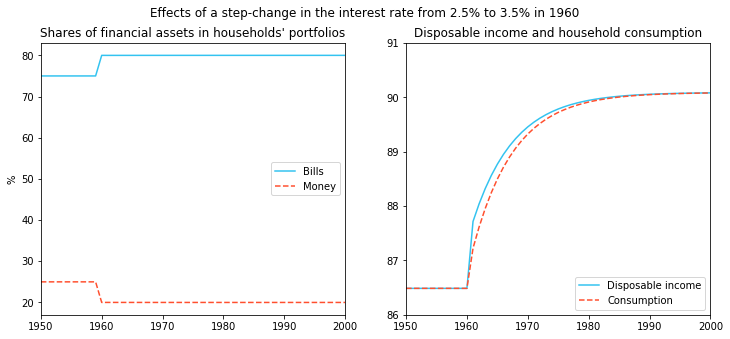

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

# Calculate bills and money holdings as a share of household wealth
results['Sb'] = results.eval('Bh / V')
results['Sh'] = results.eval('Hh / V')

# Select same timespan as the original charts
results_to_plot = results.loc[1950:2000, :]

# Set up plot areas
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle('Effects of a step-change in the interest rate from 2.5% to 3.5% in 1960')

# Recreate Figure 4.3 (shares of bills and money in households' portfolios)
ax1.set_title("Shares of financial assets in households' portfolios")

ax1.plot(results_to_plot.index, results_to_plot['Sb'] * 100,
         label='Bills',
         color='#33C3F0')
ax1.plot(results_to_plot.index, results_to_plot['Sh'] * 100,
         label='Money',
         color='#FF4F2E', linestyle='--')

ax1.set_xlim(min(results_to_plot.index), max(results_to_plot.index))
ax1.set_ylabel('%')
ax1.legend()

# Recreate Figure 4.4 (disposable income and household consumption)
ax2.set_title('Disposable income and household consumption')

ax2.plot(results_to_plot.index, results_to_plot['YD'].values,
         label='Disposable income',
         color='#33C3F0')
ax2.plot(results_to_plot.index, results_to_plot['C'].values,
         label='Consumption',
         color='#FF4F2E', linestyle='--')

ax2.set_xlim(min(results_to_plot.index), max(results_to_plot.index))
ax2.set_ylim(86, 91)
ax2.legend(loc='lower right')

plt.show()

The model shows how interest rates *increase* economic activity (the puzzling impact) because there are no mechanisms for high interest rates to depress aggregate demand.

See [here](https://github.com/ChrisThoung/website/tree/master/code/2018-07-08_fsic_pc) for this post as a Jupyter notebook along with supporting Python code.

## References

Godley, W., Lavoie, M. (2007)
*Monetary economics: An integrated approach to
credit, money, income, production and wealth*,
Palgrave Macmillan

Zezza, G. (2006) 'EViews macros for building models in *Wynne Godley and Marc Lavoie* Monetary Economics: An Integrated Approach to Credit, Money, Income, Production and Wealth'  
[http://gennaro.zezza.it/software/eviews/glch04.php](http://gennaro.zezza.it/software/eviews/glch04.php)  
[Accessed 07/07/2018]